# CZ4045 Natural Language Processing
## Assignment - 2

### Team - 15
* Tharakan Rohan Roy
* Gupta Jay
* Jose Jeswin
* Dandapath Soham
* Adrakatti Vivek

> **Warning:** This notebook was created on the Kaggle platform where it fetches data from the Kaggle directories. It will not work by default on the Jupyter Notebook Platform.

In [1]:
import os
from io import open
import torch
import time
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Parameters:
    data = '../input/wikitext2'
    model = 'FNNModel'
    emsize = 200
    ngram = 8
    nhid = 200
    nlayers = 2
    lr = 0.002
    epochs = 20
    batch_size = 16
    bptt = 35
    tied = True
    seed = 1111
    cuda = True
    log_interval = 10000
    save = 'model.pt'

args = Parameters()

In [3]:
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if args.cuda else "cpu")

## 1.2 Understanding the Preprocessing and Data Loading Functions
> **Source:** PyTorch Examples - https://github.com/pytorch/examples/blob/master/word_language_model/main.py

In [4]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        # Add words to the dictionary
        with open(path, 'r', encoding="utf8") as f:
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r', encoding="utf8") as f:
            idss = []
            for line in f:
                words = line.split() + ['<eos>']
                ids = []
                for word in words:
                    ids.append(self.dictionary.word2idx[word])
                idss.append(torch.tensor(ids).type(torch.int64))
            ids = torch.cat(idss)

        return ids

# Load data
corpus = Corpus(args.data)

In [5]:
def ngramSplit(data, bsz):
    value = []
    data = data.numpy()
    for i, word in enumerate(data):
        if i+bsz>= len(data):
            break
        word_ids = []
        for j in range(bsz+1):
            word_ids.append(data[i+j])
        value.append(word_ids)
    value = torch.LongTensor(value)
    return value.to(device)

eval_batch_size = args.batch_size
train_data = ngramSplit(corpus.train, eval_batch_size)
val_data = ngramSplit(corpus.valid, eval_batch_size)
test_data = ngramSplit(corpus.test, eval_batch_size)

In [6]:
def get_batch(source, i):
    seq_len = min(args.bptt, len(source) - 1 - i)
    data = source[i:i+seq_len, 0:args.ngram]
    target = source[i+1:i+1+seq_len, args.ngram-1:args.ngram]
    return data, target.narrow(1,0,1).contiguous().view(-1)

## 1.3 Language Model with a Feed-Forward Network Architecture

In [7]:
class FNNModel(nn.Module):
    def __init__(self, vocab_size, ninp, ngram, nhid, tie_weights=False):
        super(FNNModel, self).__init__()
        self.ntoken = vocab_size
        self.ngram = ngram
        self.ninp = ninp
        self.encoder = nn.Embedding(self.ntoken, self.ninp)
        self.fc1 = nn.Linear(self.ninp * self.ngram, nhid)
        self.decoder = nn.Linear(nhid, self.ntoken, bias = False)

        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
        # https://arxiv.org/abs/1608.05859
        # and
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
        # https://arxiv.org/abs/1611.01462
        if tie_weights:
            if nhid != ninp:
                raise ValueError(
                    'When using the tied flag, nhid must be equal to emsize')
            self.decoder.weight = self.encoder.weight

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.weight)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)
        
    def forward(self, input):
        emb = self.encoder(input).view((-1,self.ngram * self.ninp))
        output = torch.tanh(self.fc1(emb))
        decoded = self.decoder(output)
        return nn.functional.log_softmax(input = decoded, dim = 1)

In [8]:
def evaluate(model, data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, args.bptt):
            data, targets = get_batch(data_source, i)
            if args.model == 'FNNModel':
                output= model(data)
            total_loss += len(data) * criterion(output, targets).item()
    return total_loss / (len(data_source) - 1)

## 1.4 Train the model with Adam to train an 8-gram language model.

In [9]:
lr = args.lr
criterion = nn.NLLLoss()
ntokens = len(corpus.dictionary)
model = FNNModel(ntokens, args.emsize, args.ngram, args.nhid).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)

best_perplexity = None
total_loss = 0

hist_loss = []
hist_val_loss = []
hist_perplexity = []
hist_val_perplexity = []

for epoch in range(args.epochs):
    start_time = time.time()
    
    epoch_loss = 0
    epoch_perplexity = 0
    
    print("\n--- Training: {} ---".format(epoch+1))
    for batch, i in enumerate(range(0, train_data.size(0) - 1, args.bptt)):
        data, targets = get_batch(train_data, i)
        model.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        epoch_loss += loss.item()
        epoch_perplexity += math.exp(loss.item())

        if batch % args.log_interval == 0 and batch >= 0:
            cur_loss = total_loss / args.log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                      epoch, batch, len(train_data) // args.bptt, lr,
                      elapsed * 1000 / args.log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    
    hist_loss.append(epoch_loss / batch)
    hist_perplexity.append(epoch_perplexity / batch)

    print("\n--- Evaluation ---")
    crossval_loss = evaluate(model, val_data)
    crossval_perplexity = math.exp(crossval_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | valid loss {:5.2f} | '
              'valid ppl {:8.2f}'.format(epoch, crossval_loss, crossval_perplexity))
    print('-' * 89)
    
    hist_val_loss.append(crossval_loss)
    hist_val_perplexity.append(crossval_perplexity)
    
    if not best_perplexity or crossval_perplexity < best_perplexity:
        best_perplexity = crossval_perplexity
        with open(args.save, 'wb') as f:
            torch.save(model, f)
    else:
        lr /= 4.0


--- Training: 1 ---
| epoch   0 |     0/59674 batches | lr 0.002 | ms/batch  0.09 | loss  0.00 | ppl     1.00
| epoch   0 | 10000/59674 batches | lr 0.002 | ms/batch  3.52 | loss  6.52 | ppl   681.48
| epoch   0 | 20000/59674 batches | lr 0.002 | ms/batch  3.55 | loss  6.26 | ppl   521.80
| epoch   0 | 30000/59674 batches | lr 0.002 | ms/batch  3.53 | loss  6.14 | ppl   465.80
| epoch   0 | 40000/59674 batches | lr 0.002 | ms/batch  3.55 | loss  6.17 | ppl   476.28
| epoch   0 | 50000/59674 batches | lr 0.002 | ms/batch  3.54 | loss  6.19 | ppl   488.79

--- Evaluation ---
-----------------------------------------------------------------------------------------
| end of epoch   0 | valid loss  6.56 | valid ppl   703.05
-----------------------------------------------------------------------------------------

--- Training: 2 ---
| epoch   1 |     0/59674 batches | lr 0.002 | ms/batch  0.00 | loss  6.03 | ppl   415.14
| epoch   1 | 10000/59674 batches | lr 0.002 | ms/batch  3.53 | loss 

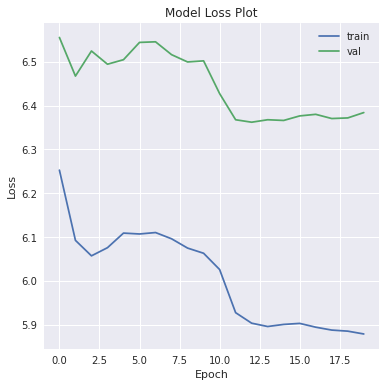

In [10]:
plt.style.use("seaborn")

fig = plt.figure(figsize =(6, 6))
plt.plot(hist_loss)
plt.plot(hist_val_loss)
plt.title('Model Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.show()

fig.savefig('loss.png', bbox_inches='tight')

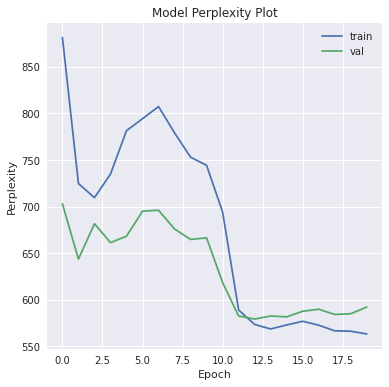

In [11]:
plt.style.use("seaborn")

fig = plt.figure(figsize =(6, 6))
plt.plot(hist_perplexity)
plt.plot(hist_val_perplexity)
plt.title('Model Perplexity Plot')
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.show()

fig.savefig('ppl.png', bbox_inches='tight')

## 1.5 Perplexity Score on the Test Set

In [12]:
with open(args.save, 'rb') as f:
    model = torch.load(f)

test_loss = evaluate(model, test_data)
print('-' * 89)
print('| test loss {:5.2f} | test ppl {:8.2f}'.format(test_loss, math.exp(test_loss)))
print('-' * 89)

-----------------------------------------------------------------------------------------
| test loss  6.29 | test ppl   539.79
-----------------------------------------------------------------------------------------


## 1.6 Sharing the Input and Output Layer Embeddings
> **Source:** PyTorch Examples - https://github.com/pytorch/examples/blob/master/word_language_model/main.py

In [13]:
lr = args.lr
criterion = nn.NLLLoss()
ntokens = len(corpus.dictionary)
model = FNNModel(ntokens, args.emsize, args.ngram, args.emsize).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)

best_perplexity = None
total_loss = 0

hist_loss = []
hist_perplexity = []

hist_val_loss = []
hist_val_perplexity = []

for epoch in range(args.epochs):
    start_time = time.time()
    
    epoch_loss = 0
    epoch_perplexity = 0
    
    print("\n--- Training: {} ---".format(epoch+1))
    for batch, i in enumerate(range(0, train_data.size(0) - 1, args.bptt)):
        data, targets = get_batch(train_data, i)
        model.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        epoch_loss += loss.item()
        epoch_perplexity += math.exp(loss.item())

        if batch % args.log_interval == 0 and batch >= 0:
            cur_loss = total_loss / args.log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                      epoch, batch, len(train_data) // args.bptt, lr,
                      elapsed * 1000 / args.log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    
    hist_loss.append(epoch_loss / batch)
    hist_perplexity.append(epoch_perplexity / batch)

    print("\n--- Evaluation ---")
    crossval_loss = evaluate(model, val_data)
    crossval_perplexity = math.exp(crossval_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | valid loss {:5.2f} | '
              'valid ppl {:8.2f}'.format(epoch, crossval_loss, crossval_perplexity))
    print('-' * 89)
    
    hist_val_loss.append(crossval_loss)
    hist_val_perplexity.append(crossval_perplexity)
    
    if not best_perplexity or crossval_perplexity < best_perplexity:
        best_perplexity = crossval_perplexity
        with open(args.save, 'wb') as f:
            torch.save(model, f)
    else:
        lr /= 4.0


--- Training: 1 ---
| epoch   0 |     0/59674 batches | lr 0.002 | ms/batch  0.00 | loss  0.00 | ppl     1.00
| epoch   0 | 10000/59674 batches | lr 0.002 | ms/batch  3.52 | loss  6.53 | ppl   682.00
| epoch   0 | 20000/59674 batches | lr 0.002 | ms/batch  3.53 | loss  6.24 | ppl   511.00
| epoch   0 | 30000/59674 batches | lr 0.002 | ms/batch  3.53 | loss  6.09 | ppl   439.74
| epoch   0 | 40000/59674 batches | lr 0.002 | ms/batch  3.53 | loss  6.09 | ppl   440.42
| epoch   0 | 50000/59674 batches | lr 0.002 | ms/batch  3.52 | loss  6.15 | ppl   470.13

--- Evaluation ---
-----------------------------------------------------------------------------------------
| end of epoch   0 | valid loss  6.57 | valid ppl   712.19
-----------------------------------------------------------------------------------------

--- Training: 2 ---
| epoch   1 |     0/59674 batches | lr 0.002 | ms/batch  0.00 | loss  5.97 | ppl   392.23
| epoch   1 | 10000/59674 batches | lr 0.002 | ms/batch  3.53 | loss 

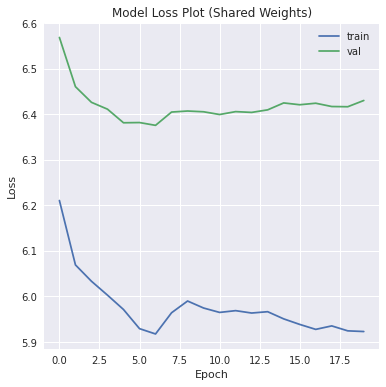

In [14]:
plt.style.use("seaborn")

fig = plt.figure(figsize =(6, 6))
plt.plot(hist_loss)
plt.plot(hist_val_loss)
plt.title('Model Loss Plot (Shared Weights)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.show()

fig.savefig('loss_shared.png', bbox_inches='tight')

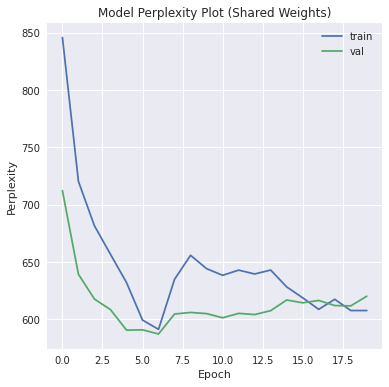

In [15]:
plt.style.use("seaborn")

fig = plt.figure(figsize =(6, 6))
plt.plot(hist_perplexity)
plt.plot(hist_val_perplexity)
plt.title('Model Perplexity Plot (Shared Weights)')
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.show()

fig.savefig('ppl_shared.png', bbox_inches='tight')

In [16]:
with open(args.save, 'rb') as f:
    model = torch.load(f)

test_loss = evaluate(model, test_data)
print('-' * 89)
print('| test loss {:5.2f} | test ppl {:8.2f}'.format(test_loss, math.exp(test_loss)))
print('-' * 89)

-----------------------------------------------------------------------------------------
| test loss  6.30 | test ppl   544.12
-----------------------------------------------------------------------------------------


## 1.7 Generate Texts using our Language Model (FNNModel)
> **Source:** PyTorch Examples - https://github.com/pytorch/examples/blob/master/word_language_model/generate.py

In [17]:
class Parameters:
    checkpoint = './model.pt'
    data = '../input/wikitext2'
    outf = 'generated.txt'
    words = 1000
    seed = 1111
    cuda =  True
    temperature = 1.0
    log_interval = 100

args = Parameters()

In [18]:
with open(args.checkpoint, 'rb') as f:
    model = torch.load(f)

model.eval()

corpus = Corpus(args.data)
ntokens = len(corpus.dictionary)

input = torch.randint(ntokens, (1, 8), dtype=torch.long).to(device)
with open(args.outf, 'w') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(args.words):
            output = model(input)
            word_weights = output.squeeze().div(args.temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            input.fill_(word_idx)

            word = corpus.dictionary.idx2word[word_idx]

            outf.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % args.log_interval == 0:
                print('| Generated {}/{} words'.format(i, args.words))

| Generated 0/1000 words
| Generated 100/1000 words
| Generated 200/1000 words
| Generated 300/1000 words
| Generated 400/1000 words
| Generated 500/1000 words
| Generated 600/1000 words
| Generated 700/1000 words
| Generated 800/1000 words
| Generated 900/1000 words
